In [1]:
import os
import sys
import glob

sys.path.append("/home/giakhang/dev/pose_sandbox/Hand_pose_estimation_3D/arm_and_hand")
sys.path.append("/home/giakhang/dev/pose_sandbox/Hand_pose_estimation_3D")

from dataloader_ann import HandArmLandmarksDataset_ANN

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from datetime import datetime
import pandas as pd

from utilities import fuse_landmarks_from_two_cameras
from functools import partial
from ann import ANN

import open3d as o3d
from utilities import convert_to_shoulder_coord
import time

from csv_writer import columns_to_normalize, fusion_csv_columns_name
from landmarks_scaler import LandmarksScaler

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [20]:
DATA_DIR = "/home/giakhang/dev/pose_sandbox/data"  
SELECTED_DATE = "*"

MODEL_DATE = "20240925"
MODEL_TIME = "1010"
NUM_HIDDEN_LAYERS = 4

In [21]:
train_paths = glob.glob(os.path.join(DATA_DIR, "{}/{}/fine_landmarks_{}_*.csv".format(SELECTED_DATE, SELECTED_DATE, "train")))
val_paths = glob.glob(os.path.join(DATA_DIR, "{}/{}/fine_landmarks_{}_*.csv".format(SELECTED_DATE, SELECTED_DATE, "val")))
test_paths = glob.glob(os.path.join(DATA_DIR, "{}/{}/fine_landmarks_{}_*.csv".format(SELECTED_DATE, SELECTED_DATE, "test")))
body_lines = [[0,2], [0, 3], [2, 4], [3, 4]]
lefthand_lines = [[0, 1], [1, 5], [5, 6], [5, 10], [5, 22], [10, 14], [14, 18], [18, 22], 
    [6, 7], [7, 8], [8, 9], 
    [10, 11], [11, 12], [12, 13], 
    [14, 15], [15, 16], [16, 17], 
    [18, 19], [19, 20], [20, 21], 
    [22, 23], [23, 24], [24, 25]]
train_body_distance_thres = 550
train_leftarm_distance_thres = 550
train_lefthand_distance_thres = 200
val_body_distance_thres=450,
val_leftarm_distance_thres=450,
val_lefthand_distance_thres=150,

scaler_path = "/home/giakhang/dev/pose_sandbox/Hand_pose_estimation_3D/arm_and_hand/runs/ann/{}/{}-{}/input_scaler.pkl".format(MODEL_DATE, MODEL_DATE, MODEL_TIME)
landmarks_scaler = LandmarksScaler(columns_to_scale=columns_to_normalize,
    scaler_path=scaler_path)

train_dataset = HandArmLandmarksDataset_ANN(train_paths, 
    body_lines, 
    lefthand_lines, 
    train_body_distance_thres, 
    train_leftarm_distance_thres, 
    train_lefthand_distance_thres,
    filter_outlier=True,
    only_keep_frames_contain_lefthand=True,
    scaler=landmarks_scaler)
val_dataset = HandArmLandmarksDataset_ANN(val_paths,
    body_lines,
    lefthand_lines,
    val_body_distance_thres,
    val_leftarm_distance_thres,
    val_lefthand_distance_thres,
    filter_outlier=True,
    only_keep_frames_contain_lefthand=True,
    scaler=landmarks_scaler)
test_dataset = HandArmLandmarksDataset_ANN(test_paths,
    body_lines,
    lefthand_lines,
    val_body_distance_thres,
    val_leftarm_distance_thres,
    val_lefthand_distance_thres,
    filter_outlier=True,
    only_keep_frames_contain_lefthand=True,
    scaler=landmarks_scaler)

/home/giakhang/.local/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [22]:
input_data = train_dataset._inputs
input_data.shape

(10876, 322)

In [23]:
ground_truth_data = train_dataset._outputs
ground_truth_data = ground_truth_data.reshape(-1, 3, 48)
ground_truth_data = np.transpose(ground_truth_data, (0, 2, 1))
ground_truth_data.shape

(10876, 48, 3)

In [25]:
input_dim = 322
output_dim = 144
hidden_dim = 256
num_hidden_layers = NUM_HIDDEN_LAYERS
dropout_rate = 0.1
#model_weight_path = "/home/giakhang/dev/pose_sandbox/Hand_pose_estimation_3D/arm_and_hand/runs/ann/{}/{}-{}/ann_{}_layers_best.pth".format(
    #MODEL_DATE, MODEL_DATE, MODEL_TIME, NUM_HIDDEN_LAYERS)
model_weight_path = "/home/giakhang/dev/pose_sandbox/Hand_pose_estimation_3D/arm_and_hand/runs/ann/{}/{}-{}/ann_best.pth".format(
    MODEL_DATE, MODEL_DATE, MODEL_TIME)

ann_model = ANN(input_dim=input_dim,
    output_dim=output_dim,
    hidden_dim=hidden_dim,
    num_hidden_layers=num_hidden_layers,
    dropout_rate=dropout_rate
)

ann_model.load_state_dict(torch.load(model_weight_path))
ann_model.to("cuda")
ann_model.eval()

ANN(
  (network): Sequential(
    (0): Linear(in_features=322, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): SiLU()
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (5): SiLU()
    (6): Dropout(p=0.1, inplace=False)
    (7): Linear(in_features=256, out_features=256, bias=True)
    (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (9): SiLU()
    (10): Dropout(p=0.1, inplace=False)
    (11): Linear(in_features=256, out_features=256, bias=True)
    (12): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (13): SiLU()
    (14): Dropout(p=0.1, inplace=False)
    (15): Linear(in_features=256, out_features=256, bias=True)
    (16): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (17): SiLU()


In [26]:
input_row = torch.Tensor(input_data)
input_row = input_row.to("cuda")

In [27]:
pred_output = ann_model(input_row)

In [28]:
pred_output = pred_output.detach().to("cpu").numpy()
pred_output = pred_output.reshape(-1, 3, 48)
pred_output = np.transpose(pred_output, (0, 2, 1))
pred_output.shape

(10876, 48, 3)

In [29]:
ground_truth_data.shape

(10876, 48, 3)

In [30]:
mae_of_first_26_joints = np.average(np.abs(ground_truth_data[:, :26, :] - pred_output[:, :26, :]))
print("Mean abs. error of the first 26 joints: {}(mm)".format(round(mae_of_first_26_joints, 2)))

Mean abs. error of the first 26 joints: 7.84(mm)


In [31]:
arm_hand_fused_names = ["left shoulder", "left elbow", "left hip", "right shoulder", "right hip", 
 "WRIST", "THUMB_CMC", "THUMB_MCP", "THUMB_IP", "THUMB_TIP", "INDEX_FINGER_MCP", 
 "INDEX_FINGER_PIP", "INDEX_FINGER_DIP", "INDEX_FINGER_TIP", "MIDDLE_FINGER_MCP", 
 "MIDDLE_FINGER_PIP", "MIDDLE_FINGER_DIP", "MIDDLE_FINGER_TIP", "RING_FINGER_MCP", 
 "RING_FINGER_PIP", "RING_FINGER_DIP", "RING_FINGER_TIP", "PINKY_MCP", "PINKY_PIP", 
 "PINKY_DIP", "PINKY_TIP", "right elbow"]

In [28]:
output_columns_name = np.array(fusion_csv_columns_name[-144:])
output_columns_name = np.reshape(output_columns_name, (3, 48))

Visualize box plots from *left_shoulder -> right_elbow* (27 joints in total)

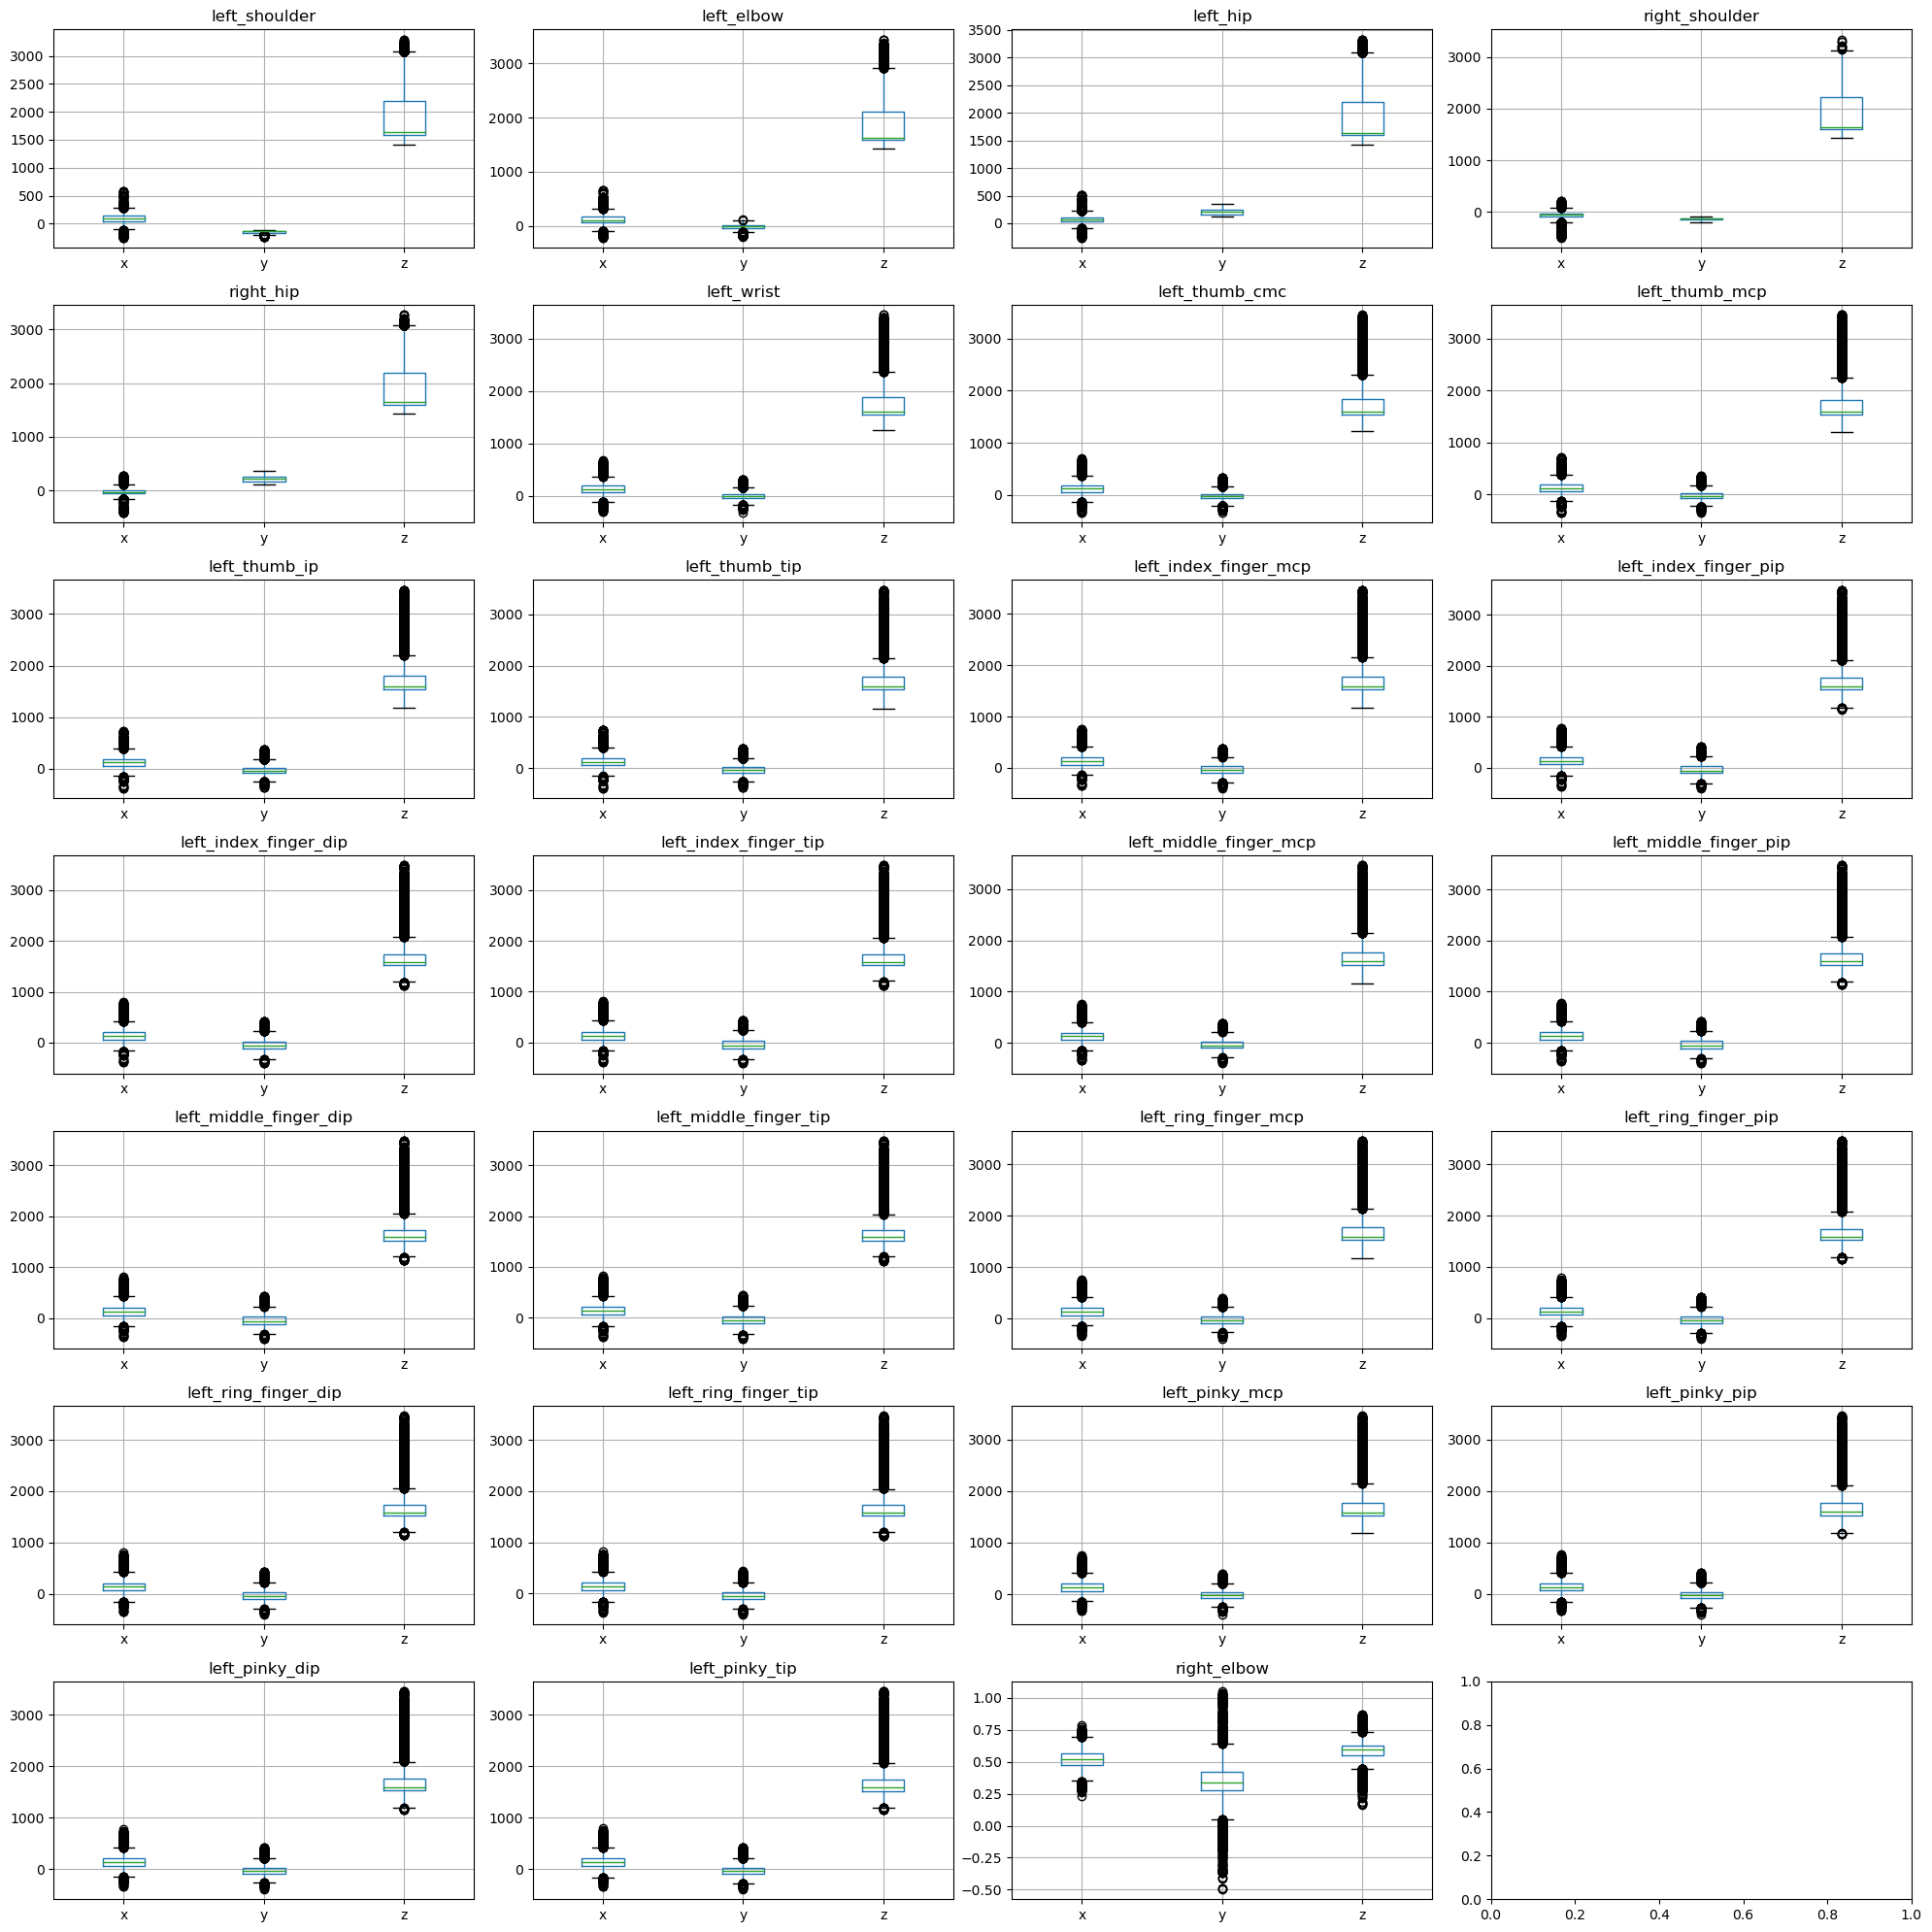

In [20]:
fig, axes = plt.subplots(7, 4, figsize=(20, 20))
axes = axes.flatten()

for i in range(len(arm_hand_fused_names)):
    ax = axes[i]
    df = pd.DataFrame(pred_output[:, i, :], columns=output_columns_name[:, i])
    df.boxplot(ax=ax)
    title = output_columns_name[:, i][0].split("_output")[0]
    ax.set_title(title)
    ax.set_xticklabels(["x", "y", "z"])

plt.tight_layout()
plt.show()

In [11]:
target_output = ground_truth_data  # shape: (N, 144)
time_sleep = .1
x = np.array([[500, 0, 0],
    [0, 0, 0]])
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(x)
lines = [[0, 0]]
colors = [[1, 0, 0] for i in range(len(lines))]
line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(x),
    lines=o3d.utility.Vector2iVector(lines)
)
line_set.colors = o3d.utility.Vector3dVector(colors)

bounding_box = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(np.array([[500,0 ,0], [0, 0, 0]])),
    lines=o3d.utility.Vector2iVector([[0, 0]])
)
    
vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(pcd)
vis.add_geometry(line_set)
vis.add_geometry(bounding_box)

for i in range(target_output.shape[0]):
    output = target_output[i, ...]  # shape: (144)
    output = output.reshape(3, 48)  # shape: (3, 48)
    output = output.T  # shape: (48, 3)
    output = output[:26, ...]  # shape: (26, 3)

    lines = body_lines.copy()
    lines.extend(lefthand_lines)

    points, _ = convert_to_shoulder_coord(output,
        arm_hand_fused_names)

    pcd.points = o3d.utility.Vector3dVector(points)
    colors = [[1, 0, 0] for i in range(len(lines))]
    line_set.points = o3d.utility.Vector3dVector(points)  
    line_set.lines = o3d.utility.Vector2iVector(lines) 
    line_set.colors = o3d.utility.Vector3dVector(colors)

    # Draw cuboid
    min_x, min_y, min_z = np.min(points, axis=0)
    max_x, max_y, max_z = np.max(points, axis=0)
    vertices = [
        [min_x, min_y, min_z], [min_x, min_y, max_z], [min_x, max_y, min_z], [min_x, max_y, max_z],
        [max_x, min_y, min_z], [max_x, min_y, max_z], [max_x, max_y, min_z], [max_x, max_y, max_z]
    ]
    vertices = np.array(vertices) 
    edges = [
        [0, 1], [1, 3], [3, 2], [2, 0],  
        [4, 5], [5, 7], [7, 6], [6, 4],  
        [0, 4], [1, 5], [2, 6], [3, 7]   
    ]
    bounding_box.points = o3d.utility.Vector3dVector(vertices)
    bounding_box.lines = o3d.utility.Vector2iVector(edges)
    bbox_colors = [[0, 1, 0] for _ in range(len(edges))]  
    bounding_box.colors = o3d.utility.Vector3dVector(bbox_colors)

    vis.update_geometry(pcd)
    vis.update_geometry(line_set)
    vis.update_geometry(bounding_box)
    vis.poll_events()
    vis.update_renderer()
        
    time.sleep(time_sleep)

vis.destroy_window()

In [12]:
target_output = output_row  # shape: (N, 144)
time_sleep = .01
x = np.array([[500, 0, 0],
    [0, 0, 0]])
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(x)
lines = [[0, 0]]
colors = [[1, 0, 0] for i in range(len(lines))]
line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(x),
    lines=o3d.utility.Vector2iVector(lines)
)
line_set.colors = o3d.utility.Vector3dVector(colors)

bounding_box = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(np.array([[500,0 ,0], [0, 0, 0]])),
    lines=o3d.utility.Vector2iVector([[0, 0]])
)
    
vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(pcd)
vis.add_geometry(line_set)
vis.add_geometry(bounding_box)

for i in range(target_output.shape[0]):
    output = target_output[i, ...]  # shape: (144)
    output = output.reshape(3, 48)  # shape: (3, 48)
    output = output.T  # shape: (48, 3)
    output = output[:26, ...]  # shape: (26, 3)

    lines = body_lines.copy()
    lines.extend(lefthand_lines)

    points, _ = convert_to_shoulder_coord(output,
        arm_hand_fused_names)

    pcd.points = o3d.utility.Vector3dVector(points)
    colors = [[1, 0, 0] for i in range(len(lines))]
    line_set.points = o3d.utility.Vector3dVector(points)  
    line_set.lines = o3d.utility.Vector2iVector(lines) 
    line_set.colors = o3d.utility.Vector3dVector(colors)

    # Draw cuboid
    min_x, min_y, min_z = np.min(points, axis=0)
    max_x, max_y, max_z = np.max(points, axis=0)
    vertices = [
        [min_x, min_y, min_z], [min_x, min_y, max_z], [min_x, max_y, min_z], [min_x, max_y, max_z],
        [max_x, min_y, min_z], [max_x, min_y, max_z], [max_x, max_y, min_z], [max_x, max_y, max_z]
    ]
    vertices = np.array(vertices) 
    edges = [
        [0, 1], [1, 3], [3, 2], [2, 0],  
        [4, 5], [5, 7], [7, 6], [6, 4],  
        [0, 4], [1, 5], [2, 6], [3, 7]   
    ]
    bounding_box.points = o3d.utility.Vector3dVector(vertices)
    bounding_box.lines = o3d.utility.Vector2iVector(edges)
    bbox_colors = [[0, 1, 0] for _ in range(len(edges))]  
    bounding_box.colors = o3d.utility.Vector3dVector(bbox_colors)

    vis.update_geometry(pcd)
    vis.update_geometry(line_set)
    vis.update_geometry(bounding_box)
    vis.poll_events()
    vis.update_renderer()
        
    time.sleep(time_sleep)

vis.destroy_window()

# Inspect val set

In [32]:
val_input = val_dataset._inputs
val_input.shape

(979, 322)

In [33]:
val_gt = val_dataset._outputs
val_gt = val_gt.reshape(-1, 3, 48)
val_gt = np.transpose(val_gt, (0, 2, 1))
val_gt.shape

(979, 48, 3)

In [34]:
val_input = torch.Tensor(val_input)
val_input = val_input.to("cuda")
val_preds = ann_model(val_input)
val_preds = val_preds.detach().to("cpu").numpy()
val_preds = val_preds.reshape(-1, 3, 48)
val_preds = np.transpose(val_preds, (0, 2, 1))
val_preds.shape

(979, 48, 3)

In [35]:
mae_of_first_26_joints = np.average(np.abs(val_gt[:, :26, :] - val_preds[:, :26, :]))
print("Mean abs. error of the first 26 joints: {}(mm)".format(round(mae_of_first_26_joints, 2)))

Mean abs. error of the first 26 joints: 7.28(mm)


Visualize box plots from *left_shoulder -> right_elbow* (27 joints in total) from *val set*

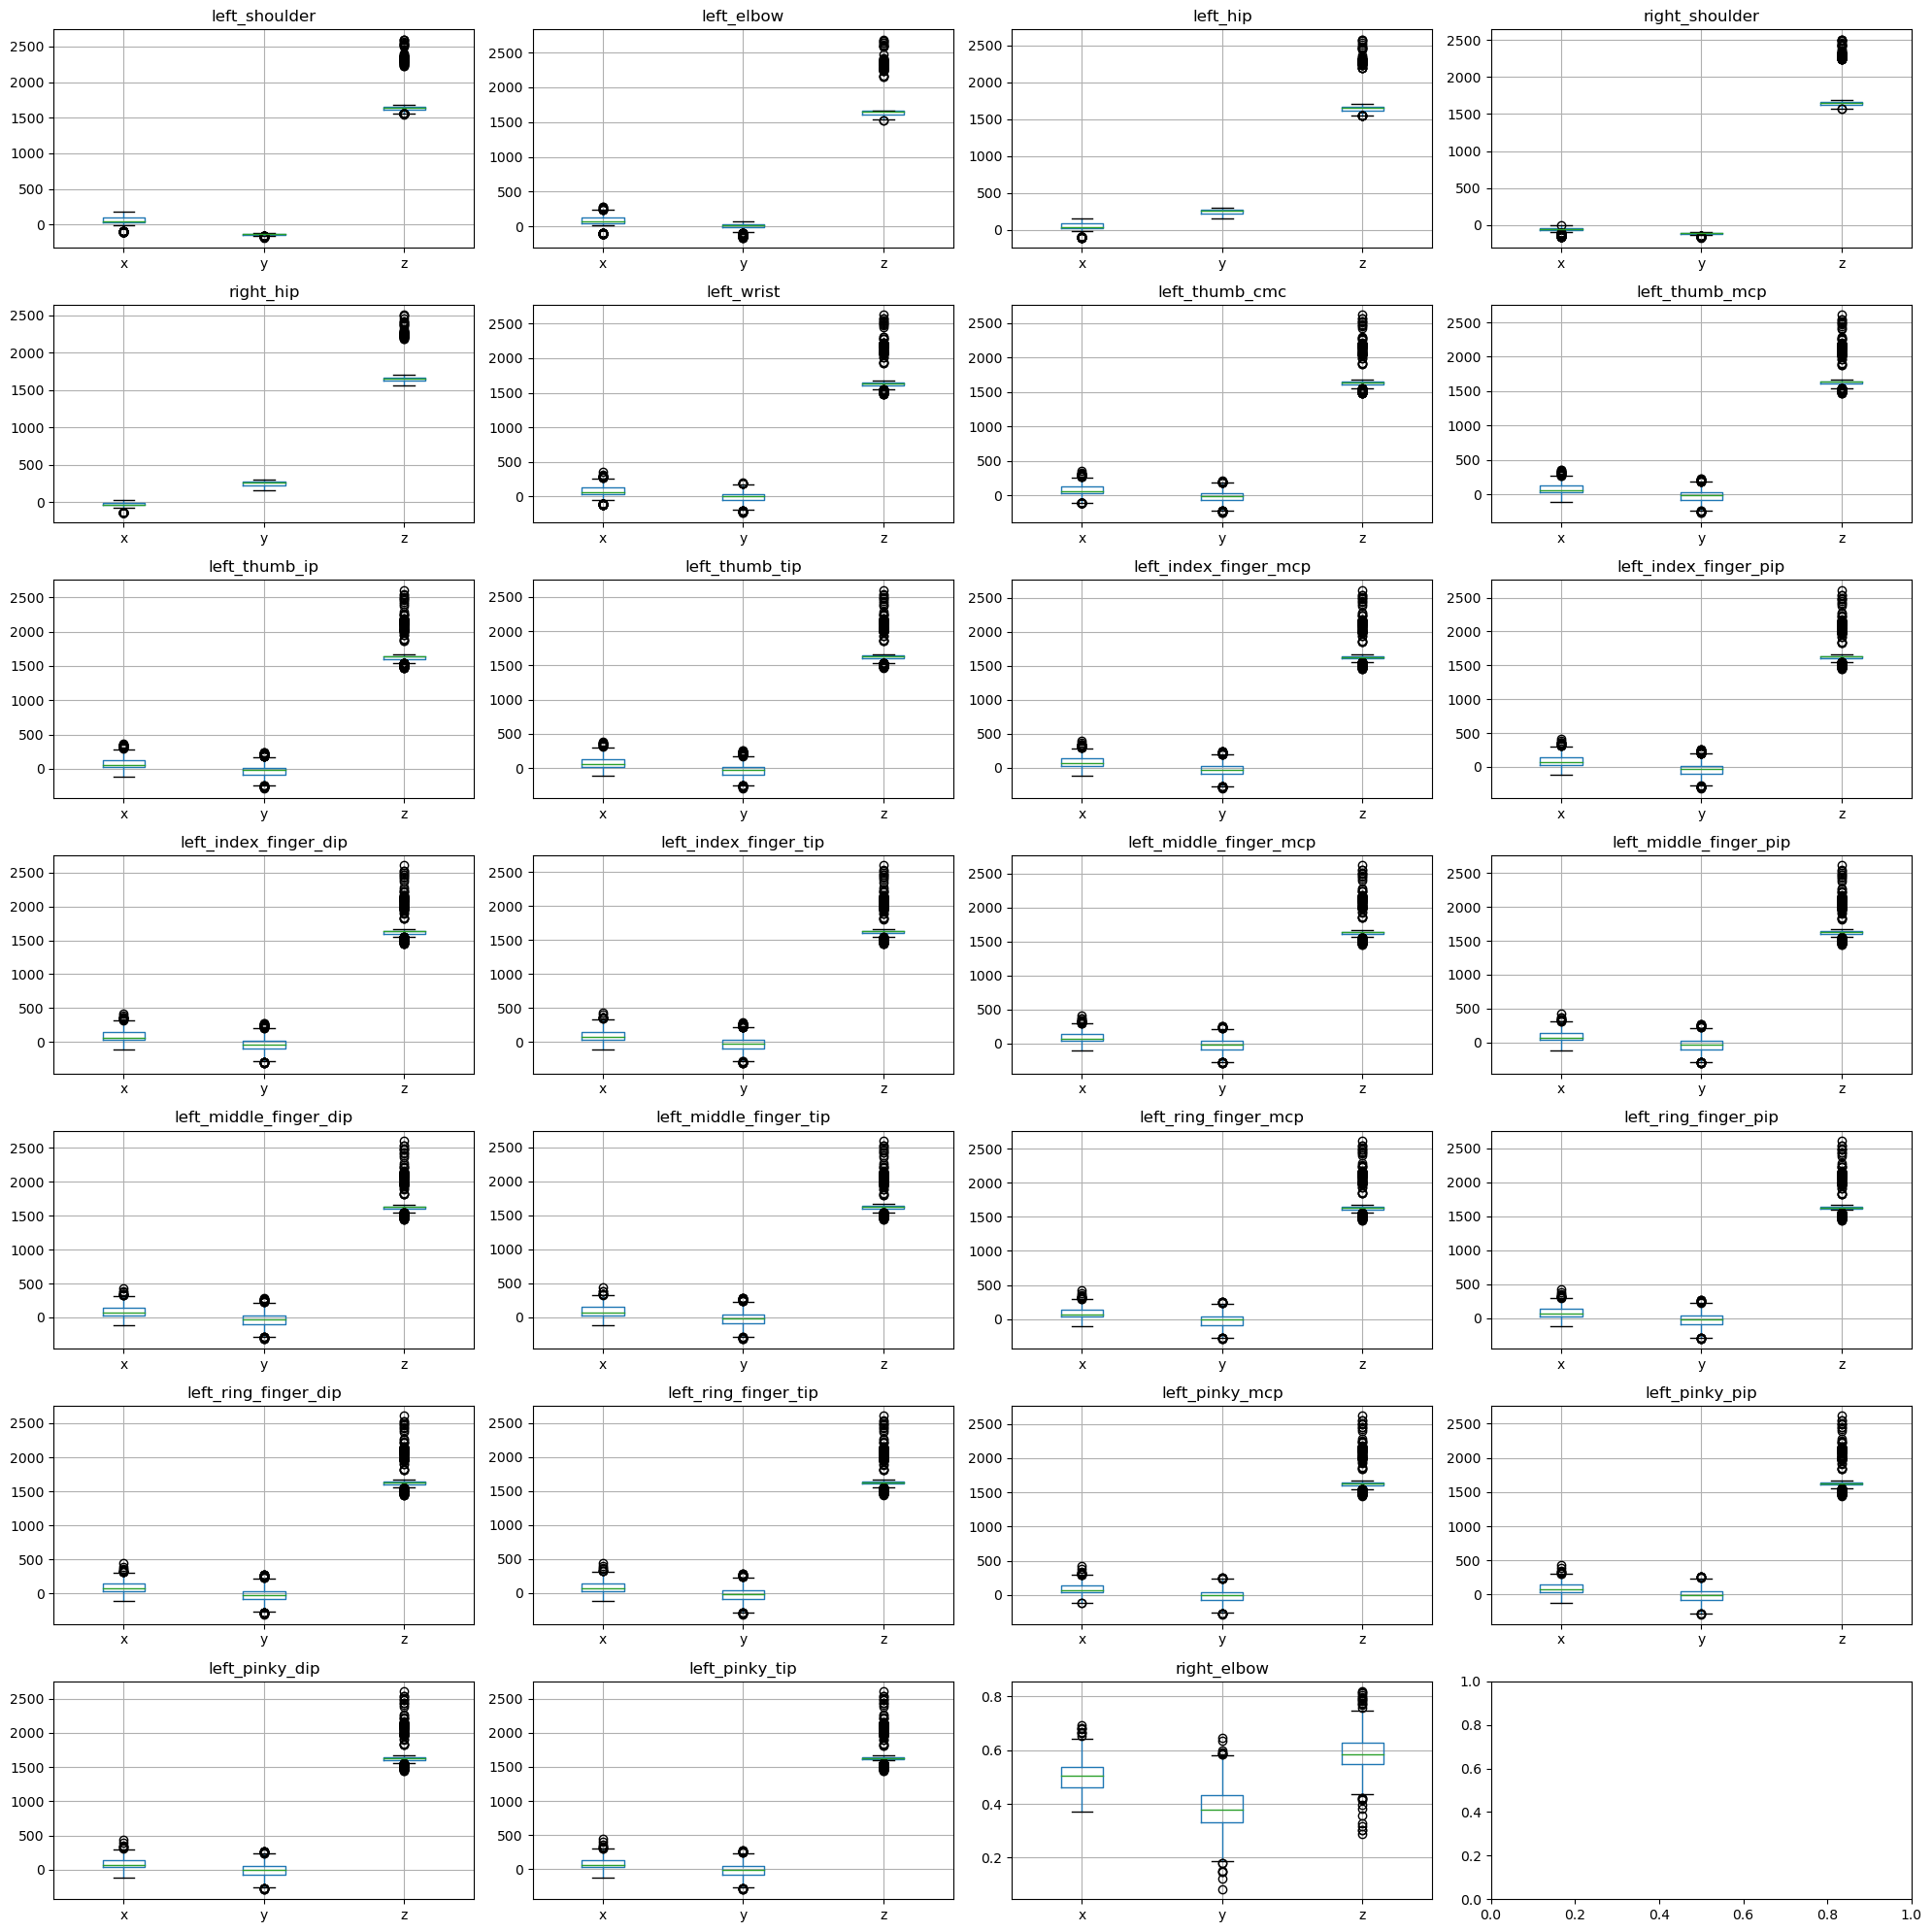

In [30]:
fig, axes = plt.subplots(7, 4, figsize=(20, 20))
axes = axes.flatten()

for i in range(len(arm_hand_fused_names)):
    ax = axes[i]
    df = pd.DataFrame(val_preds[:, i, :], columns=output_columns_name[:, i])
    df.boxplot(ax=ax)
    title = output_columns_name[:, i][0].split("_output")[0]
    ax.set_title(title)
    ax.set_xticklabels(["x", "y", "z"])

plt.tight_layout()
plt.show()

In [12]:
target_output = val_gt # shape: (N, 144)
time_sleep = .1
x = np.array([[500, 0, 0],
    [0, 0, 0]])
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(x)
lines = [[0, 0]]
colors = [[1, 0, 0] for i in range(len(lines))]
line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(x),
    lines=o3d.utility.Vector2iVector(lines)
)
line_set.colors = o3d.utility.Vector3dVector(colors)

bounding_box = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(np.array([[500,0 ,0], [0, 0, 0]])),
    lines=o3d.utility.Vector2iVector([[0, 0]])
)
    
vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(pcd)
vis.add_geometry(line_set)
vis.add_geometry(bounding_box)

for i in range(target_output.shape[0]):
    output = target_output[i, ...]  # shape: (144)
    output = output.reshape(3, 48)  # shape: (3, 48)
    output = output.T  # shape: (48, 3)
    output = output[:26, ...]  # shape: (26, 3)

    lines = body_lines.copy()
    lines.extend(lefthand_lines)

    points, _ = convert_to_shoulder_coord(output,
        arm_hand_fused_names)

    pcd.points = o3d.utility.Vector3dVector(points)
    colors = [[1, 0, 0] for i in range(len(lines))]
    line_set.points = o3d.utility.Vector3dVector(points)  
    line_set.lines = o3d.utility.Vector2iVector(lines) 
    line_set.colors = o3d.utility.Vector3dVector(colors)

    # Draw cuboid
    min_x, min_y, min_z = np.min(points, axis=0)
    max_x, max_y, max_z = np.max(points, axis=0)
    vertices = [
        [min_x, min_y, min_z], [min_x, min_y, max_z], [min_x, max_y, min_z], [min_x, max_y, max_z],
        [max_x, min_y, min_z], [max_x, min_y, max_z], [max_x, max_y, min_z], [max_x, max_y, max_z]
    ]
    vertices = np.array(vertices) 
    edges = [
        [0, 1], [1, 3], [3, 2], [2, 0],  
        [4, 5], [5, 7], [7, 6], [6, 4],  
        [0, 4], [1, 5], [2, 6], [3, 7]   
    ]
    bounding_box.points = o3d.utility.Vector3dVector(vertices)
    bounding_box.lines = o3d.utility.Vector2iVector(edges)
    bbox_colors = [[0, 1, 0] for _ in range(len(edges))]  
    bounding_box.colors = o3d.utility.Vector3dVector(bbox_colors)

    vis.update_geometry(pcd)
    vis.update_geometry(line_set)
    vis.update_geometry(bounding_box)
    vis.poll_events()
    vis.update_renderer()
        
    time.sleep(time_sleep)

vis.destroy_window()

In [17]:
target_output = val_preds # shape: (N, 144)
time_sleep = .1
x = np.array([[500, 0, 0],
    [0, 0, 0]])
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(x)
lines = [[0, 0]]
colors = [[1, 0, 0] for i in range(len(lines))]
line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(x),
    lines=o3d.utility.Vector2iVector(lines)
)
line_set.colors = o3d.utility.Vector3dVector(colors)

bounding_box = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(np.array([[500,0 ,0], [0, 0, 0]])),
    lines=o3d.utility.Vector2iVector([[0, 0]])
)
    
vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(pcd)
vis.add_geometry(line_set)
vis.add_geometry(bounding_box)

for i in range(target_output.shape[0]):
    output = target_output[i, ...]  # shape: (144)
    output = output.reshape(3, 48)  # shape: (3, 48)
    output = output.T  # shape: (48, 3)
    output = output[:26, ...]  # shape: (26, 3)

    lines = body_lines.copy()
    lines.extend(lefthand_lines)

    points, _ = convert_to_shoulder_coord(output,
        arm_hand_fused_names)

    pcd.points = o3d.utility.Vector3dVector(points)
    colors = [[1, 0, 0] for i in range(len(lines))]
    line_set.points = o3d.utility.Vector3dVector(points)  
    line_set.lines = o3d.utility.Vector2iVector(lines) 
    line_set.colors = o3d.utility.Vector3dVector(colors)

    # Draw cuboid
    min_x, min_y, min_z = np.min(points, axis=0)
    max_x, max_y, max_z = np.max(points, axis=0)
    vertices = [
        [min_x, min_y, min_z], [min_x, min_y, max_z], [min_x, max_y, min_z], [min_x, max_y, max_z],
        [max_x, min_y, min_z], [max_x, min_y, max_z], [max_x, max_y, min_z], [max_x, max_y, max_z]
    ]
    vertices = np.array(vertices) 
    edges = [
        [0, 1], [1, 3], [3, 2], [2, 0],  
        [4, 5], [5, 7], [7, 6], [6, 4],  
        [0, 4], [1, 5], [2, 6], [3, 7]   
    ]
    bounding_box.points = o3d.utility.Vector3dVector(vertices)
    bounding_box.lines = o3d.utility.Vector2iVector(edges)
    bbox_colors = [[0, 1, 0] for _ in range(len(edges))]  
    bounding_box.colors = o3d.utility.Vector3dVector(bbox_colors)

    vis.update_geometry(pcd)
    vis.update_geometry(line_set)
    vis.update_geometry(bounding_box)
    vis.poll_events()
    vis.update_renderer()
        
    time.sleep(time_sleep)

vis.destroy_window()

# Inspect test

In [36]:
test_input = test_dataset._inputs
test_input.shape

(417, 322)

In [37]:
test_gt = test_dataset._outputs
test_gt = test_gt.reshape(-1, 3, 48)
test_gt = np.transpose(test_gt, (0, 2, 1))
test_gt.shape

(417, 48, 3)

In [38]:
test_input = torch.Tensor(test_input)
test_input = test_input.to("cuda")
test_preds = ann_model(test_input)
test_preds = test_preds.detach().to("cpu").numpy()
test_preds = test_preds.reshape(-1, 3, 48)
test_preds = np.transpose(test_preds, (0, 2, 1))
test_preds.shape

(417, 48, 3)

In [39]:
mae_of_first_26_joints = np.average(np.abs(test_gt[:, :26, :] - test_preds[:, :26, :]))
print("Mean abs. error of the first 26 joints: {}(mm)".format(round(mae_of_first_26_joints, 2)))

Mean abs. error of the first 26 joints: 9.96(mm)


In [30]:
target_output = test_preds # shape: (N, 144)
time_sleep = .1
x = np.array([[500, 0, 0],
    [0, 0, 0]])
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(x)
lines = [[0, 0]]
colors = [[1, 0, 0] for i in range(len(lines))]
line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(x),
    lines=o3d.utility.Vector2iVector(lines)
)
line_set.colors = o3d.utility.Vector3dVector(colors)

bounding_box = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(np.array([[500,0 ,0], [0, 0, 0]])),
    lines=o3d.utility.Vector2iVector([[0, 0]])
)
    
vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(pcd)
vis.add_geometry(line_set)
vis.add_geometry(bounding_box)

for i in range(target_output.shape[0]):
    output = target_output[i, ...]  # shape: (144)
    output = output.reshape(3, 48)  # shape: (3, 48)
    output = output.T  # shape: (48, 3)
    output = output[:26, ...]  # shape: (26, 3)

    lines = body_lines.copy()
    lines.extend(lefthand_lines)

    points, _ = convert_to_shoulder_coord(output,
        arm_hand_fused_names)

    pcd.points = o3d.utility.Vector3dVector(points)
    colors = [[1, 0, 0] for i in range(len(lines))]
    line_set.points = o3d.utility.Vector3dVector(points)  
    line_set.lines = o3d.utility.Vector2iVector(lines) 
    line_set.colors = o3d.utility.Vector3dVector(colors)

    # Draw cuboid
    min_x, min_y, min_z = np.min(points, axis=0)
    max_x, max_y, max_z = np.max(points, axis=0)
    vertices = [
        [min_x, min_y, min_z], [min_x, min_y, max_z], [min_x, max_y, min_z], [min_x, max_y, max_z],
        [max_x, min_y, min_z], [max_x, min_y, max_z], [max_x, max_y, min_z], [max_x, max_y, max_z]
    ]
    vertices = np.array(vertices) 
    edges = [
        [0, 1], [1, 3], [3, 2], [2, 0],  
        [4, 5], [5, 7], [7, 6], [6, 4],  
        [0, 4], [1, 5], [2, 6], [3, 7]   
    ]
    bounding_box.points = o3d.utility.Vector3dVector(vertices)
    bounding_box.lines = o3d.utility.Vector2iVector(edges)
    bbox_colors = [[0, 1, 0] for _ in range(len(edges))]  
    bounding_box.colors = o3d.utility.Vector3dVector(bbox_colors)

    vis.update_geometry(pcd)
    vis.update_geometry(line_set)
    vis.update_geometry(bounding_box)
    vis.poll_events()
    vis.update_renderer()
        
    time.sleep(time_sleep)

vis.destroy_window()